# Imports

In [1]:
import os # Interact with os functions
import numpy as np # Numerical computations
import tensorflow as tf # The Deep Learning Framework the script will use
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt # For creating visualizations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # For computing and displaying the confusion matrix

2024-07-27 13:52:15.307947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 13:52:15.308062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 13:52:15.444106: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Parameters

In [2]:
img_width, img_height = 192, 192 # Dimensions to which images will be resized
batch_size = 32 # Number of samples processed before the internal state of the model is updated
epochs = 100 # Number of times the training dataset gets passed through
num_classes = 4 # Number of output classes (in the case of this project, there are 4 emotions)
supported_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp'] # List of accepted image file extensions
data_dir = '/kaggle/input/dog-emotion/Dog Emotion/' # Path to the folder containing the dataset

# Filtering supported files
Function to filter all the image files with supported file extensions:

In [3]:
def filter_supported_files(filenames):
    return [filename for filename in filenames if os.path.splitext(filename)[1].lower() in supported_extensions]

# Listing subfolders and image files

In [4]:
# Get the list of subfolders (4 classifications/categories) in the dataset folder
subfolders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

# Get the image files from the subfolders, collects all images in subdirectories, filtering by supported extensions
image_files = []
for folder in subfolders:
    folder_path = os.path.join(data_dir, folder)
    file_list = os.listdir(folder_path)
    image_files.extend([(folder, filename) for filename in filter_supported_files(file_list)])
    
# Shuffle the list of the supported image files to ensure random distribution
np.random.shuffle(image_files)

# Creating TensorFlow dataset

In [5]:
data = [] # This will store the list of tuples containing image arrays and their corresponding integer labels (folder indexes)
for folder, filename in image_files:
    img_path = os.path.join(data_dir, folder, filename)
    # Loads image and resizes it
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
    # img_to_array: converts the image to a numpy array
    # Scales pixel values to [0, 1] range
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    # Assign integer label to each class and append the image-data + label to the data-array
    label = subfolders.index(folder)
    data.append((img_array, label))
    
# Shuffle the dataset
# np.random.shuffle(data)

# Splitting the data
Split the Data to 75% training data, 15% validation data and 10% testing data.

In [6]:
train_size = int(len(data) * 0.75)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

# Creating TensorFlow datasets for training, validation, and testing
- tf.data.Dataset.from_generator: creates a TensorFlow dataset from a generator
- output_signature: Specifies the shape and type of the data
- batch(batch_size): Combines elements into batches
- repeat(): Repeats the dataset indefinitely to ensure there is enough data for the training set and validation set (training was sometimes interrupted because there was to little data).

In [7]:
# Training set
training_set = tf.data.Dataset.from_generator(
    lambda: ((x, y) for x, y in data[:train_size]),
    output_signature=(
        tf.TensorSpec(shape=(img_width, img_height, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(batch_size).repeat()

# Validation set
validation_set = tf.data.Dataset.from_generator(
    lambda: ((x, y) for x, y in data[train_size:train_size+val_size]),
    output_signature=(
        tf.TensorSpec(shape=(img_width, img_height, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(batch_size).repeat()

# Testing set
testing_set = tf.data.Dataset.from_generator(
    lambda: ((x, y) for x, y in data[train_size+val_size:]),
    output_signature=(
        tf.TensorSpec(shape=(img_width, img_height, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(batch_size)

# Visualize a sample of the dataset
Displays a few images with their labels.

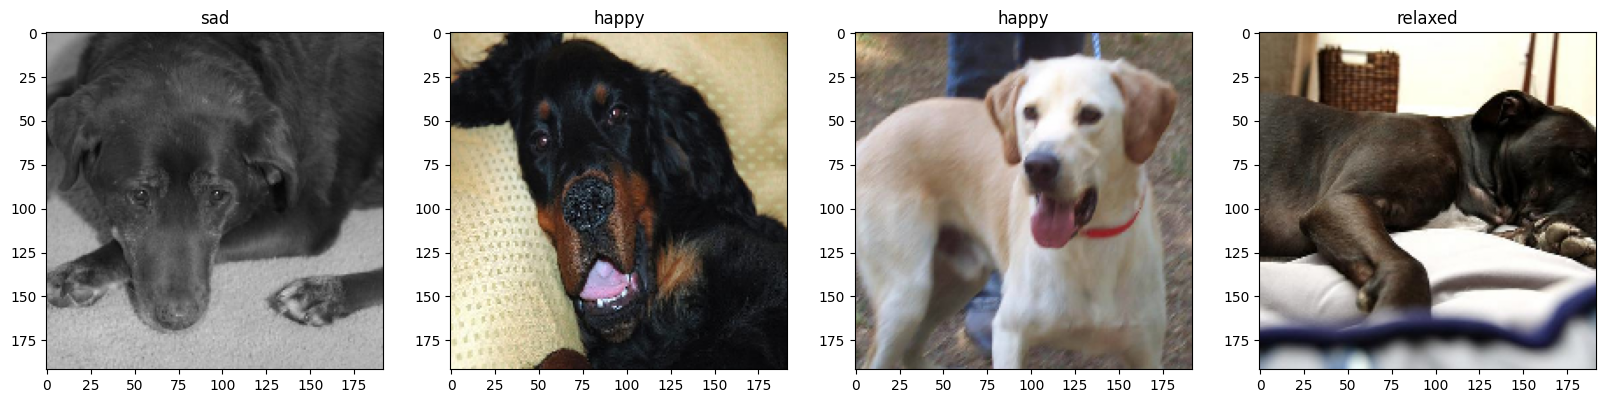

In [8]:
batch = next(iter(training_set))
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, (img, label) in enumerate(zip(batch[0][:4], batch[1][:4])):
    ax[idx].imshow(img)
    ax[idx].title.set_text(subfolders[label.numpy()])
plt.show()

# Data augmentation
Applies random transformations to images to enhance the model's generalization ability.

In [9]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Define the training dataset with augmentation
training_set = training_set.map(lambda x, y: (data_augmentation(x), y))

# Custom Model architecture
- Conv2D: Convolutional layer for feature extraction.
- MaxPooling2D: Reduces the spatial dimensions.
- Flatten: Converts 3D feature maps to 1D feature vectors.
- Dense: Fully connected layer.
- Dropout: Regularization to prevent overfitting (randomly drops out a number of output units from the layer during the training process).
- softmax: Activation function for multi-class classification.

In [10]:
model = Sequential([
    Input(shape=(img_width, img_height, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile the model
- optimizer: Adam optimizer.
- loss: Sparse categorical cross-entropy loss function.
- metrics: Metrics to evaluate during training and testing (accuracy).

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary();

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 190, 190, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 95, 95, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 93, 93, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model
- steps_per_epoch: Number of steps (batches of samples) to yield from the dataset before declaring one epoch finished.
- validation_steps: Number of steps to evaluate during validation at the end of each epoch.
- model.fit: Trains the model for a fixed number of epochs.

In [12]:
steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size

history = model.fit(
    training_set,
    epochs=epochs,
    validation_data=validation_set,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/100


2024-07-27 13:53:12.449355: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 7.1116, expected 6.14436
2024-07-27 13:53:12.449425: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 8.19328, expected 7.22604
2024-07-27 13:53:12.449436: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.32094, expected 5.3537
2024-07-27 13:53:12.449445: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.75636, expected 6.78912
2024-07-27 13:53:12.449453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.95135, expected 4.98411
2024-07-27 13:53:12.449461: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.55348, expected 5.58625
2024-07-27 13:53:12.449468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 7.16697, expected 6.19973
2024-07-27 13:53:12.449476: E external/local_xla/xla/serv

 1/93 ━━━━━━━━━━━━━━━━━━━━ 11:43 8s/step - accuracy: 0.3438 - loss: 1.3887

I0000 00:00:1722088396.554771      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 255ms/step - accuracy: 0.2682 - loss: 1.5217 - val_accuracy: 0.2726 - val_loss: 1.4041
Epoch 2/100


2024-07-27 13:53:40.833886: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 72202: 7.40374, expected 6.49634
2024-07-27 13:53:40.833955: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 72203: 7.94692, expected 7.03952
2024-07-27 13:53:40.833965: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 72204: 7.58213, expected 6.67474
2024-07-27 13:53:40.833973: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 72205: 6.82999, expected 5.92259
2024-07-27 13:53:40.833981: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 72206: 5.74865, expected 4.84125
2024-07-27 13:53:40.833989: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 72207: 6.3285, expected 5.4211
2024-07-27 13:53:40.833997: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 72208: 6.77901, expected 5.87161
2024-07-27 13:53:40.834005: E

93/93 ━━━━━━━━━━━━━━━━━━━━ 33s 247ms/step - accuracy: 0.2564 - loss: 1.3928 - val_accuracy: 0.2570 - val_loss: 1.3987
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 242ms/step - accuracy: 0.2621 - loss: 1.3862 - val_accuracy: 0.2359 - val_loss: 1.3867
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 0.2481 - loss: 1.3867 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 247ms/step - accuracy: 0.2469 - loss: 1.3876 - val_accuracy: 0.2447 - val_loss: 1.3864
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 0.2530 - loss: 1.3885 - val_accuracy: 0.2711 - val_loss: 1.3817
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 0.2509 - loss: 1.3822 - val_accuracy: 0.2500 - val_loss: 1.3807
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 245ms/step - accuracy: 0.2602 - loss: 1.3937 - val_accuracy: 0.2359 - val_loss: 1.3850
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 0.2532 - loss: 1.3837 - val_accuracy

# Evaluating the model on testing set
- test_steps: Number of steps to evaluate during testing.
- model.evaluate: Evaluates the model on the testing dataset.

In [13]:
test_steps = test_size // batch_size

test_loss, test_accuracy = model.evaluate(testing_set, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4195 - loss: 1.1962
Test Loss: 1.2043275833129883, Test Accuracy: 0.4270833432674408


# Plot training and validation metrics
Displays training and validation accuracy and loss over epochs.

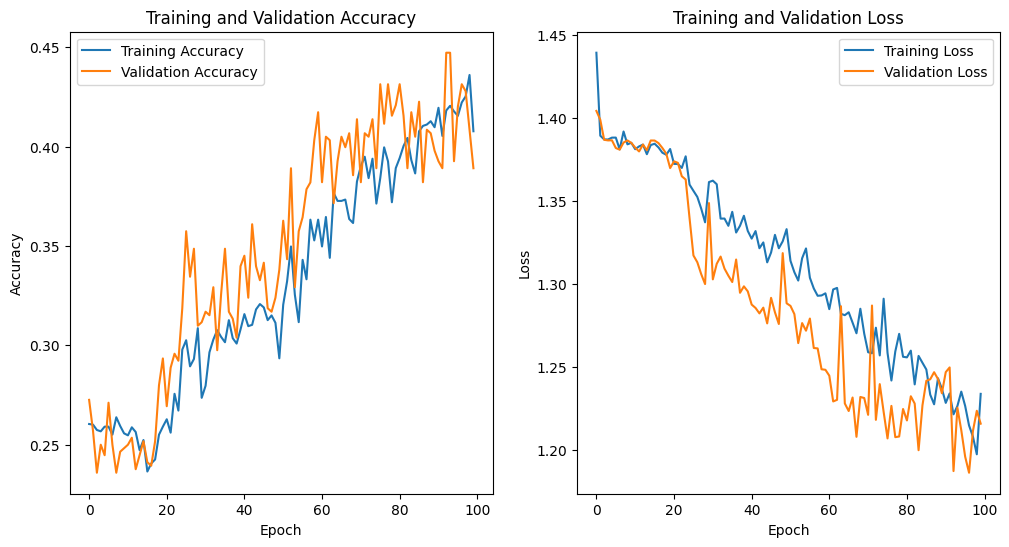

In [14]:
# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Making predictions on the test set

In [15]:
test_images = []
test_labels = []
for img, label in testing_set.unbatch().take(test_size):
    test_images.append(img.numpy())
    test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

 7/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  

2024-07-27 14:31:39.481046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4747: 3.74478, expected 3.26402
2024-07-27 14:31:39.481164: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14710: 3.74478, expected 3.26402
2024-07-27 14:31:39.481258: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 24675: 3.74478, expected 3.26402
2024-07-27 14:31:39.481347: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 34638: 3.74478, expected 3.26402
2024-07-27 14:31:39.481916: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 108304: 7.48941, expected 6.62807
2024-07-27 14:31:39.481960: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 108306: 6.34613, expected 5.48478
2024-07-27 14:31:39.481979: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 108312: 7.29029, expected 6.42894
2024-07-27 14:31:39.48199

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


# Computing and plotting the confusion matrix

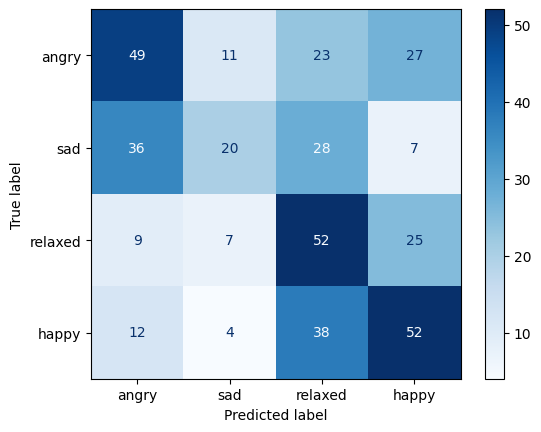

In [16]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=subfolders)
disp.plot(cmap=plt.cm.Blues)
plt.show()